# Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from helper_functions import *

# (1) Load Data

In [4]:
# Load in full Data CSV
filename = './matchup_data_all.csv'
df = pd.read_csv(filename)

# Use helper function to create new win column that describes if home_team won, loss or draw
# This will be our target column
df['target'] = df[['home_score', 'away_score']].apply(add_win_column, axis = 1)
df.sort_values('date_value', inplace = True, ascending=False)
df = df.drop(columns = ['url', 'date', 'home_record', 'away_record'])
df.head()


# Make dataframe that is just the features inorder for feature variance analysis
df_feat = df.drop(columns = ['target', 'date_value', 'home_team', 'away_team', 'home_score', 'away_score', 'week'])
print(len(df_feat.columns))
list(df_feat)



32


['home_possession',
 'away_possession',
 'home_pass_acc',
 'away_pass_acc',
 'home_sot',
 'away_sot',
 'home_saves',
 'away_saves',
 'home_fouls',
 'away_fouls',
 'home_corners',
 'away_corners',
 'home_crosses',
 'away_crosses',
 'home_touches',
 'away_touches',
 'home_tackles',
 'away_tackles',
 'home_ints',
 'away_ints',
 'home_aerials',
 'away_aerials',
 'home_clearances',
 'away_clearances',
 'home_offsides',
 'away_offsides',
 'home_goal_kicks',
 'away_goal_kicks',
 'home_throwins',
 'away_throwins',
 'home_longballs',
 'away_longballs']

# Feature Variance Analysis

In [5]:
vifs = []
for i, feature in enumerate(list(df_feat)):
    vif_tup = (feature, variance_inflation_factor(df_feat.values, i))
    vifs.append( vif_tup )
vifs


[('home_possession', 680.701498080627),
 ('away_possession', 600.6859549597091),
 ('home_pass_acc', 996.1016985703549),
 ('away_pass_acc', 888.3849048955051),
 ('home_sot', 7.270767218536324),
 ('away_sot', 6.172409065556261),
 ('home_saves', 6.287660708873903),
 ('away_saves', 7.090955484260247),
 ('home_fouls', 13.111950083367153),
 ('away_fouls', 12.455623805545246),
 ('home_corners', 8.729434785612003),
 ('away_corners', 7.439265382377548),
 ('home_crosses', 16.31750629097872),
 ('away_crosses', 13.822444975990956),
 ('home_touches', 550.9832120077979),
 ('away_touches', 542.4138177235843),
 ('home_tackles', 15.097304097777911),
 ('away_tackles', 14.525367070179678),
 ('home_ints', 8.091690249647515),
 ('away_ints', 8.415804689950393),
 ('home_aerials', 10.666689852224783),
 ('away_aerials', 10.51729974145111),
 ('home_clearances', 12.55513971486953),
 ('away_clearances', 15.420994119467558),
 ('home_offsides', 2.7662337903569836),
 ('away_offsides', 2.5140735757033563),
 ('home_go

# Model Training and Testing on Already Played Games

In [6]:
clfs = [LogisticRegression(), RandomForestClassifier()]
X = df_feat.values

y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
print(type(y_train))

<class 'numpy.ndarray'>


In [7]:
print(X_test)
for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

[[65 35 83 ... 26 59 79]
 [55 45 82 ... 15 46 74]
 [48 52 78 ... 27 61 70]
 ...
 [29 71 55 ... 20 79 46]
 [58 42 76 ... 34 70 61]
 [70 30 87 ... 10 61 83]]
<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.75 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.6973684210526315 



# Modelling on Games Yet to be Played (ie without stats)

In [8]:
def create_game(df, home, away, date_val, target, window):
    # Return a df of averaged stats from previous 5 games that represents a predicted game
    
    new_game = {
        'date_value': date_val,
        'home_team': home,
        'away_team': away,
        'target': target,
        'home_score': 0,
        'away_score': 0,
        'home_possession': 0,
        'away_possession': 0,
        'home_pass_acc': 0,
        'away_pass_acc': 0,
        'home_sot': 0,
        'away_sot': 0,
        'home_saves': 0,
        'away_saves': 0,
        'home_fouls': 0,
        'away_fouls': 0,
        'home_corners': 0,
        'away_corners': 0,
        'home_crosses': 0,
        'away_crosses': 0,
        'home_touches': 0,
        'away_touches': 0,
        'home_tackles': 0,
        'away_tackles': 0,
        'home_ints': 0,
        'away_ints': 0,
        'home_aerials': 0,
        'away_aerials': 0,
        'home_clearances': 0,
        'away_clearances': 0,
        'home_offsides': 0,
        'away_offsides': 0,
        'home_goal_kicks': 0,
        'away_goal_kicks': 0,
        'home_throwins': 0,
        'away_throwins': 0,
        'home_longballs': 0, 
        'away_longballs': 0
    }

    # I added in a few more checks to the "week" feature and how it affects "window"
    
    # Gets the week the game took place in
    week = df[df["date_value"] == date_val][df["home_team"] == home].iloc[0]["week"]
    
    if week == 1:
        # If it's a first-week game, we have no previous game data
        # date_value=0 will indicate that the game is invalid
        new_game["date_value"] = 0
        new_df = pd.DataFrame.from_records([new_game])
        return new_df
    
    # Adjusts window if there aren't enough games
    if week < window + 1:
        window = week - 1
    
    
    # Extract and sum up previous 5 games from Home team
    num_found = 0
    for index, data in df.iterrows():
        if int(data['date_value']) >= int(date_val): continue  # Skip until we get to the point in time we are predicting for
        if num_found >= window: break
            
        if data['home_team'] == home:
            new_game['home_score'] += data['home_score']
            new_game['home_possession'] += data['home_possession']
            new_game['home_pass_acc'] += data['home_pass_acc']
            new_game['home_sot'] += data['home_sot']
            new_game['home_saves'] += data['home_saves']
            new_game['home_fouls'] += data['home_fouls']
            new_game['home_corners'] += data['home_corners']
            new_game['home_crosses'] += data['home_crosses']
            new_game['home_touches'] += data['home_touches']
            new_game['home_tackles'] += data['home_tackles']
            new_game['home_ints'] += data['home_ints']
            new_game['home_aerials'] += data['home_aerials']
            new_game['home_clearances'] += data['home_clearances']
            new_game['home_offsides'] += data['home_offsides']
            new_game['home_goal_kicks'] += data['home_goal_kicks']
            new_game['home_throwins'] += data['home_throwins']
            new_game['home_longballs'] += data['home_longballs']
        elif data['away_team'] == home:
            new_game['home_score'] += data['away_score']
            new_game['home_possession'] += data['away_possession']
            new_game['home_pass_acc'] += data['away_pass_acc']
            new_game['home_sot'] += data['away_sot']
            new_game['home_saves'] += data['away_saves']
            new_game['home_fouls'] += data['away_fouls']
            new_game['home_corners'] += data['away_corners']
            new_game['home_crosses'] += data['away_crosses']
            new_game['home_touches'] += data['away_touches']
            new_game['home_tackles'] += data['away_tackles']
            new_game['home_ints'] += data['away_ints']
            new_game['home_aerials'] += data['away_aerials']
            new_game['home_clearances'] += data['away_clearances']
            new_game['home_offsides'] += data['away_offsides']
            new_game['home_goal_kicks'] += data['away_goal_kicks']
            new_game['home_throwins'] += data['away_throwins']
            new_game['home_longballs'] += data['away_longballs']
        else: continue

        num_found += 1

    # Do the same for the Away Team
    num_found = 0
    for index, data in df.iterrows():
        if int(data['date_value']) >= int(date_val): continue  # Skip until we get to the point in time we are predicting for
        if num_found >= window: break
            
        if data['home_team'] == away:
            new_game['away_score'] += data['home_score']
            new_game['away_possession'] += data['home_possession']
            new_game['away_pass_acc'] += data['home_pass_acc']
            new_game['away_sot'] += data['home_sot']
            new_game['away_saves'] += data['home_saves']
            new_game['away_fouls'] += data['home_fouls']
            new_game['away_corners'] += data['home_corners']
            new_game['away_crosses'] += data['home_crosses']
            new_game['away_touches'] += data['home_touches']
            new_game['away_tackles'] += data['home_tackles']
            new_game['away_ints'] += data['home_ints']
            new_game['away_aerials'] += data['home_aerials']
            new_game['away_clearances'] += data['home_clearances']
            new_game['away_offsides'] += data['home_offsides']
            new_game['away_goal_kicks'] += data['home_goal_kicks']
            new_game['away_throwins'] += data['home_throwins']
            new_game['away_longballs'] += data['home_longballs']
        elif data['away_team'] == away:
            new_game['away_score'] += data['away_score']
            new_game['away_possession'] += data['away_possession']
            new_game['away_pass_acc'] += data['away_pass_acc']
            new_game['away_sot'] += data['away_sot']
            new_game['away_saves'] += data['away_saves']
            new_game['away_fouls'] += data['away_fouls']
            new_game['away_corners'] += data['away_corners']
            new_game['away_crosses'] += data['away_crosses']
            new_game['away_touches'] += data['away_touches']
            new_game['away_tackles'] += data['away_tackles']
            new_game['away_ints'] += data['away_ints']
            new_game['away_aerials'] += data['away_aerials']
            new_game['away_clearances'] += data['away_clearances']
            new_game['away_offsides'] += data['away_offsides']
            new_game['away_goal_kicks'] += data['away_goal_kicks']
            new_game['away_throwins'] += data['away_throwins']
            new_game['away_longballs'] += data['away_longballs']
        else: continue

        num_found += 1

    # Average out new game according to window size
    not_ints = ["date_value", "home_team", "away_team", "target"]
    for key, val in new_game.items():
        if key in not_ints: continue
        new_game[key] = val / window 
    
    new_df = pd.DataFrame.from_records([new_game])
    return new_df

In [9]:
# We have to make our own train_test_split function inorder to get test sets that still have the team names and date_value in them
# This way we can do our 5 game average and then predict

def split_data(X, y):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, 80) # 80/20 split
    
    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]

    return X_train, X_test, y_train, y_test

In [10]:

# This will be the dataframe containing all the transformed data
transformed_df = pd.DataFrame()

# Loop through all games in order from most to least recent
count = 0
for _, row in df.iterrows():
    home_team_name = row["home_team"]
    away_team_name = row["away_team"]
    matchID = row["date_value"]
    target = row["target"]

    # Get the average stats for each team's last 5 games and organize it into df
    fict_game = create_game(df, home_team_name, away_team_name, matchID, target, window=5)
    
    # If it's a first week game, dont include it cause we have no valid past data
    if fict_game["date_value"][0] == 0:
        count += 1
        continue
    
    # Add this df to accumulated df
    transformed_df = transformed_df.append(fict_game)

    # Progress tracking. This loop takes a while
    count += 1
    if count % 20 == 0:
        print("{}/{} games transformed".format(count, len(df)))

# Resets game indices
transformed_df = transformed_df.reset_index(drop=True)

/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

20/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

40/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

60/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

80/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

100/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

120/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

140/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

160/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

180/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

200/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

220/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

240/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

260/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

280/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

300/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

320/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

340/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

360/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

400/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

420/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

440/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

460/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

480/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

500/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

520/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

540/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

560/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

580/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

600/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

620/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

640/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

660/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

680/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

700/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

720/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

740/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

780/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

800/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

820/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

840/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

860/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

880/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

900/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

920/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

940/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

960/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

980/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

1000/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

1020/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

1040/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

1060/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

1080/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

1100/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

1120/1140 games transformed


/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/leozheng/anaconda3/lib/python3.6/site-packages/ipykernel_

In [13]:
# Make a copy of dataset for preprocesssing (to preserve original)
transformed_df_prep = transformed_df.copy(deep=True)

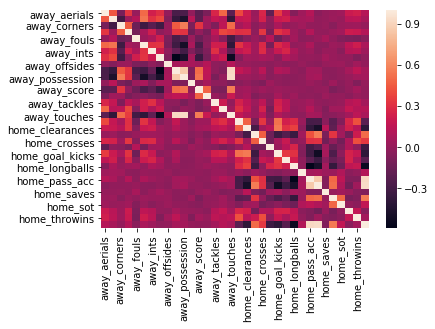

In [14]:
# Makes heatmap to look for highly correlated features
import seaborn as sns
transformed_df_feat = transformed_df_prep.drop(["date_value", "home_team", "away_team", "target"], axis=1)
features = list(transformed_df_feat.columns)

corr = transformed_df_feat[features].corr()
_ = sns.heatmap(corr)

In [15]:
# PCA transforms touches, possession, and pass acc (all mutually correlated)
from sklearn.decomposition import PCA

# Sets of correlated features
correlated_sets = [
    ["home_possession", "home_pass_acc", "home_touches"],
    ["away_possession", "away_pass_acc", "away_touches"]
]


# Names to give the new derived features
corr_set_names = [
    "home_poss", "away_poss"
]

for i in range(len(correlated_sets)):
    
    # Grabs correlated metrics
    corr_set = correlated_sets[i]

    # Reduces column dimensions to 1 through PCA transform
    pca = PCA(n_components=1)
    correlated_components = transformed_df_prep[corr_set]
    correlated_components = pd.DataFrame(pca.fit_transform(correlated_components))[0]

    # Arranges new dataset
    transformed_df_prep.drop(corr_set, axis=1, inplace=True)
    transformed_df_prep[corr_set_names[i]] = correlated_components



In [16]:
# Z-scales data
from sklearn.preprocessing import StandardScaler

no_scale_data = transformed_df_prep[["date_value", "home_team", "away_team", "target"]]
transformed_df_prep.drop(no_scale_data.columns, axis=1, inplace=True)
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(transformed_df_prep))
scaled.columns = transformed_df_prep.columns
transformed_df_prep = scaled.join(no_scale_data)

In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from statistics import stdev
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Shuffles df
transformed_df_prep = transformed_df_prep.sample(frac=1).reset_index(drop=True)

# Cross-validation
folds = 10
fold_size = len(transformed_df) // folds

accuracies = []
recalls = []
precisions = []
f1score = []

accuracies_svm = []
recalls_svm = []
precisions_svm = []
f1score_svm = []

accuracies_gnb = []
recalls_gnb = []
precisions_gnb = []
f1score_gnb = []

accuracies_lgr = []
recalls_lgr = []
precisions_lgr = []
f1score_lgr = []

for i in range(folds):
    
    # Constructs train and test sets based on current fold
    train = pd.DataFrame()
    for j in range(folds):
        if j == i:
            test = transformed_df_prep.iloc[j*fold_size : (j+1)*fold_size]
        else:
            train = train.append(transformed_df_prep.iloc[j*fold_size : (j+1)*fold_size])
            
    # Splits into X and y
    X_train = train.drop(columns = ["date_value", "home_team", "away_team", "target"])
    y_train = train["target"]
    X_test = test.drop(columns = ["date_value", "home_team", "away_team", "target"])
    y_test = test["target"]
    
    # Makes model, trains it, and runs it on test set
    clf = RandomForestClassifier(n_estimators=300, max_depth=8)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    # Evaluates predicions agains actuals
    accuracies.append(accuracy_score(y_test, predictions))
    recalls.append(recall_score(y_test, predictions, average="macro"))
    precisions.append(precision_score(y_test, predictions, average="macro"))
    f1score.append(f1_score(y_test, predictions, average="macro"))
    
    clf_svm = svm.SVC(gamma=0.001, C=100.)
    clf_svm.fit(X_train, y_train)
    predictions_svm = clf_svm.predict(X_test)
    
    accuracies_svm.append(accuracy_score(y_test, predictions_svm))
    recalls_svm.append(recall_score(y_test, predictions_svm, average="macro"))
    precisions_svm.append(precision_score(y_test, predictions_svm, average="macro"))
    f1score_svm.append(f1_score(y_test, predictions_svm, average="macro"))
    
    clf_gnb = GaussianNB()
    clf_gnb.fit(X_train, y_train)
    predictions_gnb = clf_gnb.predict(X_test)
    
    accuracies_gnb.append(accuracy_score(y_test, predictions_gnb))
    recalls_gnb.append(recall_score(y_test, predictions_gnb, average="macro"))
    precisions_gnb.append(precision_score(y_test, predictions_gnb, average="macro"))
    f1score_gnb.append(f1_score(y_test, predictions_gnb, average="macro"))
    
    clf_lgr = LogisticRegression(random_state=0)
    clf_lgr.fit(X_train, y_train)
    predictions_lgr = clf_lgr.predict(X_test)
    
    accuracies_lgr.append(accuracy_score(y_test, predictions_lgr))
    recalls_lgr.append(recall_score(y_test, predictions_lgr, average="macro"))
    precisions_lgr.append(precision_score(y_test, predictions_lgr, average="macro"))
    f1score_lgr.append(f1_score(y_test, predictions_lgr, average="macro"))
    
print("Accuracy:  {:4f} (std={:4f})".format(sum(accuracies) / folds, stdev(accuracies)))
print("Recall:    {:4f} (std={:4f})".format(sum(recalls) / folds, stdev(recalls)))
print("Precision: {:4f} (std={:4f})".format(sum(precisions) / folds, stdev(precisions)))
print("F1 Score:  {:4f} (std={:4f})".format(sum(f1score) / folds, stdev(precisions)))

print("Accuracy svm:  {:4f} (std={:4f})".format(sum(accuracies_svm) / folds, stdev(accuracies_svm)))
print("Recall svm:    {:4f} (std={:4f})".format(sum(recalls_svm) / folds, stdev(recalls_svm)))
print("Precision svm: {:4f} (std={:4f})".format(sum(precisions_svm) / folds, stdev(precisions_svm)))
print("F1 Score svm:  {:4f} (std={:4f})".format(sum(f1score_svm) / folds, stdev(precisions_svm)))

print("Accuracy gnb:  {:4f} (std={:4f})".format(sum(accuracies_gnb) / folds, stdev(accuracies_gnb)))
print("Recall gnb:    {:4f} (std={:4f})".format(sum(recalls_gnb) / folds, stdev(recalls_gnb)))
print("Precision gnb: {:4f} (std={:4f})".format(sum(precisions_gnb) / folds, stdev(precisions_gnb)))
print("F1 Score gnb:  {:4f} (std={:4f})".format(sum(f1score_gnb) / folds, stdev(precisions_gnb)))

print("Accuracy lgr:  {:4f} (std={:4f})".format(sum(accuracies_lgr) / folds, stdev(accuracies_lgr)))
print("Recall lgr:    {:4f} (std={:4f})".format(sum(recalls_lgr) / folds, stdev(recalls_lgr)))
print("Precision lgr: {:4f} (std={:4f})".format(sum(precisions_lgr) / folds, stdev(precisions_lgr)))
print("F1 Score lgr:  {:4f} (std={:4f})".format(sum(f1score_lgr) / folds, stdev(precisions_lgr)))

/Users/leozheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/leozheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/leozheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/leozheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/leozh

Accuracy:  0.561261 (std=0.053728)
Recall:    0.452825 (std=0.049928)
Precision: 0.409168 (std=0.081790)
F1 Score:  0.406442 (std=0.081790)
Accuracy svm:  0.551351 (std=0.035734)
Recall svm:    0.447336 (std=0.028599)
Precision svm: 0.368247 (std=0.032200)
F1 Score svm:  0.395553 (std=0.032200)
Accuracy gnb:  0.534234 (std=0.045354)
Recall gnb:    0.477884 (std=0.044809)
Precision gnb: 0.477005 (std=0.072357)
F1 Score gnb:  0.463945 (std=0.072357)
Accuracy lgr:  0.542342 (std=0.043683)
Recall lgr:    0.449199 (std=0.041687)
Precision lgr: 0.414806 (std=0.065572)
F1 Score lgr:  0.408202 (std=0.065572)


/Users/leozheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/leozheng/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[14,  2, 17],
       [ 5,  1, 20],
       [ 7,  0, 45]])